In [ ]:
from ISS.algorithms.utils.lanelet2_utils import get_solid_checker
import lanelet2
from lanelet2.projection import UtmProjector

hd_map = "/home/shaohang/work_space/autonomous_vehicle/ISS/ros1_ws/src/iss_manager/maps/simple_road_v1.osm"
projector = UtmProjector(lanelet2.io.Origin(0., 0.))
loadedMap, load_errors = lanelet2.io.loadRobust(hd_map, projector)
traffic_rules = lanelet2.traffic_rules.create(lanelet2.traffic_rules.Locations.Germany,
                                            lanelet2.traffic_rules.Participants.Vehicle)
_lanemap_collision_checker, _solid_points = get_solid_checker(loadedMap, 0.35, 0.2)


import pickle
from scipy.spatial import KDTree
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

_spatial_temporal_obstacles_array = pickle.load(open('/home/shaohang/work_space/autonomous_vehicle/ISS/obstacle.pkl', 'rb'))
_spatial_temporal_obstacles = KDTree(_spatial_temporal_obstacles_array)

_obstacles_info_list = pickle.load(open('/home/shaohang/work_space/autonomous_vehicle/ISS/obstacle_info.pkl', 'rb'))


def get_circle_centers(x, y, heading_angle, length, width, num_circles=3):
    spacing = length / num_circles
    centers = [(x + spacing * (j - (num_circles + 1) / 2) * math.cos(heading_angle),
                y + spacing * (j - (num_circles + 1) / 2) * math.sin(heading_angle))
               for j in range(1, num_circles + 1)]
    r = 0.5 * math.sqrt((length / num_circles) ** 2 + width ** 2)
    return centers, r

def collision_check(path):
    if _lanemap_collision_checker.check_path(path): #TODO: not accurate
            return True, 0
    if _spatial_temporal_obstacles is None:
        return False, 0
    ego_length = 0.35
    ego_width = 0.2
    for i, wpt in enumerate(path):
        ego_heading = wpt[2]
        ego_center = [wpt[0], wpt[1]]
        ego_circle_centers, ego_radius = get_circle_centers(ego_center[0], ego_center[1], ego_heading, ego_length, ego_width)
        for ego_circle_center in ego_circle_centers:
            ego_circle_center_array = np.array(ego_circle_center)
            possible_obstacles = _spatial_temporal_obstacles.query_ball_point(ego_circle_center_array, 6 * ego_radius)
            for idx in possible_obstacles:
                obs_info = _obstacles_info_list[idx]
                if obs_info[0] in [(i + j) for j in range(-1, 2)]:                    
                    dist = np.linalg.norm(ego_circle_center_array - _spatial_temporal_obstacles.data[idx])
                    if dist < (ego_radius + obs_info[1]):
                        return True, 1
    return False, 0

In [ ]:
# path = [(-1.8074783100221432, 2.206385686242163, -1.6036325274856873), (-1.8095257816090056, 2.144054002958361, -1.6036263169811231), (-1.8115518721556714, 2.0823615513159535, -1.6037030066087776), (-1.8135442900545469, 2.0218358861543657, -1.604658431197463), (-1.8155375122180404, 1.9629954713924576, -1.6062756807305576), (-1.817549210775526, 1.906318723785117, -1.6080403390563371), (-1.8195651082031927, 1.8522170004667844, -1.6098599956908282), (-1.8215652874355857, 1.801039991733964, -1.611790993012299), (-1.8235323543448794, 1.7530833905265542, -1.6138674456394775), (-1.825449865467672, 1.7085912740232914, -1.6160694794739112), (-1.8272999777054995, 1.6677536490071614, -1.6183788594375417), (-1.82906411891613, 1.630706238626224, -1.620779972843447), (-1.830723746243208, 1.5975304879615961, -1.6232589323349358), (-1.8322610991279134, 1.5682535929533037, -1.6257946692184277), (-1.833659747172213, 1.5428485083665415, -1.628372701053427), (-1.834905620275296, 1.5212338077391458, -1.6309912852652713), (-1.835988024293048, 1.503273892327243, -1.6336488250959127), (-1.8369002663792062, 1.4887789948639714, -1.6363431068473686), (-1.8376402899665252, 1.4775051614973067, -1.6390709897803863), (-1.838211334037251, 1.469154237801428, -1.641827835345208), (-1.8386226149803964, 1.4633738592602972, -1.644606028212734), (-1.8388900271512403, 1.4597574459682632, -1.6473900304619284), (-1.8390368569296747, 1.457844200769843, -1.6501335483692054), (-1.8390945046413765, 1.4571191097307215, -1.6501335483692054)]
path = [(-1.7962644895393522, 2.2063729100209066, -1.7049612450493004), (-1.7965359500754248, 2.2043617300637357, -2.177842272691726), (-1.7978789563241424, 2.202428041624946, -2.593265949982222), (-1.8008132201957907, 2.200635777743124, -2.80347829462308), (-1.8053680428983905, 2.199034226020584, -2.9100675563710507), (-1.811205016464087, 2.1976581440575, -2.9703525155047226), (-1.8177407247187576, 2.196527899358459, -3.0078707386105026), (-1.8242694437039284, 2.195649625335017, -3.032978292168144), (-1.8300858416359083, 2.195015384962779, -3.0507192734578723), (-1.8346076785128564, 2.194603335505592, -3.0637636456934114), (-1.8374985054767636, 2.1943778899258004, -3.0735654035327404), (-1.8387903640259393, 2.1942898725264266, -3.0735654035327404)]

path_array = np.array(path)
plt.plot(path_array[:, 0], path_array[:, 1])
plt.axes().set_aspect('equal')


print(collision_check(path))


In [ ]:
fstate = [0.0, 0.00019255548863934997, -3.1647781921479606e-08, 7.811971383972763e-05, 8.002265276798871e-05, 0.0]
ixs = [-1.7999999766374717, -1.8000776322179153, -1.8004971672710643, -1.801566937212654, -1.803556789021954, -1.80668982024387, -1.8111196255947695, -1.8168824509589225, -1.8238139879150213, -1.831424091654355, -1.838729404972141, -1.8442760741610562, -1.8471893178879186, -1.8472369397800283, -1.8448376615295123, -1.8412312840676806, -1.838556724841395, -1.8382277771923425, -1.8390329694586676, -1.8393762042153348]
iys = [3.0000004249406906, 2.9998131416047698, 2.998801319136702, 2.9962206422124784, 2.9914139861245923, 2.9838100284940574, 2.972919416207456, 2.958326705224156, 2.9396763436865583, 2.916651566756515, 2.888946200260421, 2.8562684874344964, 2.8185179005033065, 2.7757958400827896, 2.7284070389844284, 2.6768882277621335, 2.6220212809620818, 2.564559595721552, 2.504907991893715, 2.44350017256991]
iyaws = [-1.9638614105459484, -1.963860915532004, -1.9638411180676076, -1.9636597772816682, -1.9628207872641878, -1.96016053680041, -1.9535000827088285, -1.9392916686774837, -1.9122645950013615, -1.8650894626767511, -1.788266699115778, -1.692657502560904, -1.6073202261043045, -1.5417887230816045, -1.5046288518582984, -1.5039953118785034, -1.5454973282088214, -1.5797269694196454, -1.5833788251919627, -1.5706706511505248]
ds = [7.811971383972763e-05, 9.775445024726136e-05, 0.00011536974310337102, 0.00012948480567885495, 0.000139149577161667, 0.0001438821329791204, 0.00014360609512009223, 0.00013858804245722703, 0.00012937492106914101, 0.00011673145456262638, 0.00010157755439485502, 8.492573019558289e-05, 6.781850008935397e-05, 5.126580101770395e-05, 3.6182399061365116e-05, 2.3325299762469822e-05, 1.3231158446754031e-05, 6.153690545763427e-06, 2.0010819190550456e-06, 2.7339917640228917e-07]

In [ ]:
ixs = [-1.8119095403461296, -1.811923845278366, -1.8120116133715876, -1.8122372270572726, -1.8126551544852405, -1.8133099164308193, -1.814235999477094, -1.8154576855911673, -1.816988781443858, -1.818832258068391, -1.8209798485329298, -1.8234118937505792, -1.8261000023931961, -1.829008198897057, -1.8320921863770028, -1.835299618039761]
iys = [3.0505110972225333, 3.0502471633482084, 3.0486277930849446, 3.044465075835152, 3.0367538559781044, 3.0246717310903533, 3.007579047277079, 2.9850188900074865, 2.9567170695588776, 2.922582101639163, 2.88270518575156, 2.8373601969997324, 2.7870038304872558, 2.732275663543288, 2.6739981154556034, 2.613176459317402]
iyaws = [-1.6249422752052922, -1.624942274120822, -1.6249422199888635, -1.6249417061339146, -1.6249393288165006, -1.6249318810082731, -1.624913581264145, -1.6248755014779561, -1.6248053209110895, -1.6246874974871488, -1.6245039109515975, -1.624255161150523, -1.624005289356025, -1.6237720162077265, -1.6235675539488104, -1.6234069153117547]
d_list = [0.05200792064610153, 0.05189405650248561, 0.051175905160737965, 0.0494754066577525, 0.04662882216070277, 0.04265101452831903, 0.037699728872165286, 0.03203987311791619, 0.026007798566634103, 0.01997558045604613, 0.01431529852182101, 0.009363317558846278, 0.005384567982505001, 0.002536826389953159, 0.0008349961213962309, 0.00011538782136655268]


In [ ]:

fxs = []
fys = []
for ix, iy, iyaw, d in zip(ixs, iys, iyaws, d_list):
    fx = ix - d * math.sin(iyaw)
    fy = iy + d * math.cos(iyaw)
    fxs.append(fx)
    fys.append(fy)


yaws = []
for i in range(len(fxs) - 1):
    dx = fxs[i + 1] - fxs[i]
    dy = fys[i + 1] - fys[i]
    yaws.append(math.atan2(dy, dx))
    
ids = []
for i in range(len(ixs) - 1):
    dx = ixs[i + 1] - ixs[i]
    dy = iys[i + 1] - iys[i]
    ids.append(math.sqrt(dx ** 2 + dy ** 2))

ds = []
for i in range(len(fxs) - 1):
    dx = fxs[i + 1] - fxs[i]
    dy = fys[i + 1] - fys[i]
    ds.append(math.sqrt(dx ** 2 + dy ** 2))



ics = []
cs = []
for i in range(len(yaws) - 1):
    cs.append((yaws[i + 1] - yaws[i]) / ds[i])
    ics.append((iyaws[i + 1] - iyaws[i]) / ids[i])

plt.figure()
plt.plot(ixs, iys, 'b')
plt.plot(fxs, fys, 'r')
plt.axes().set_aspect('equal')

plt.figure()
plt.plot(iyaws, 'b')
plt.plot(yaws, 'r')

plt.figure()
plt.plot(ics, 'b')
plt.plot(cs, 'r')

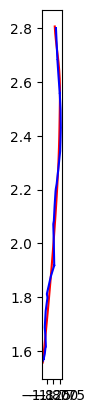

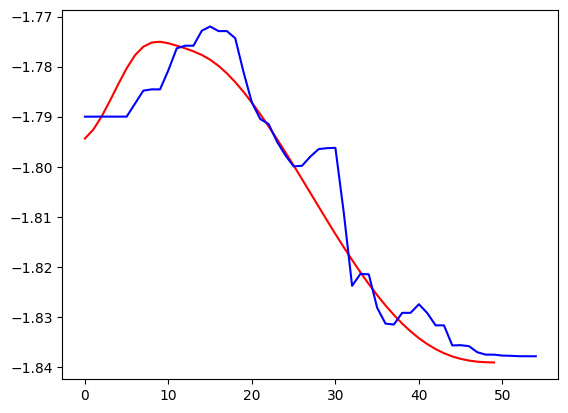

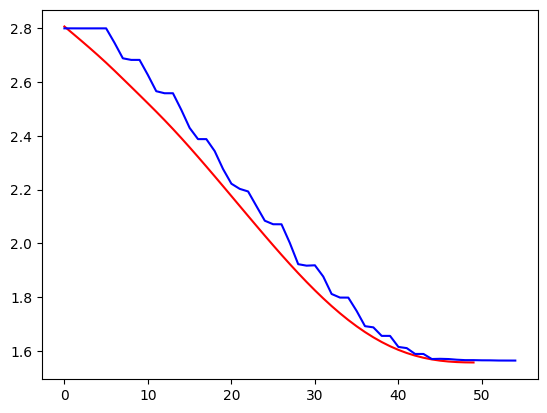

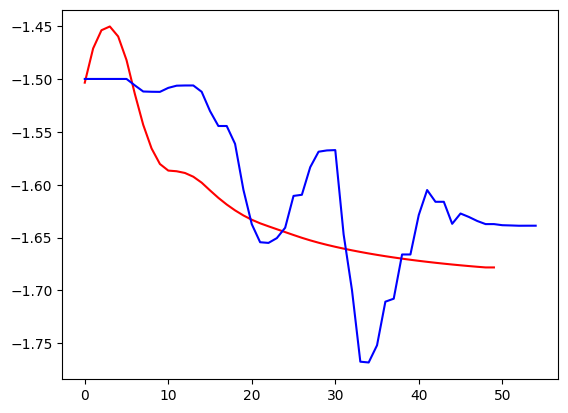

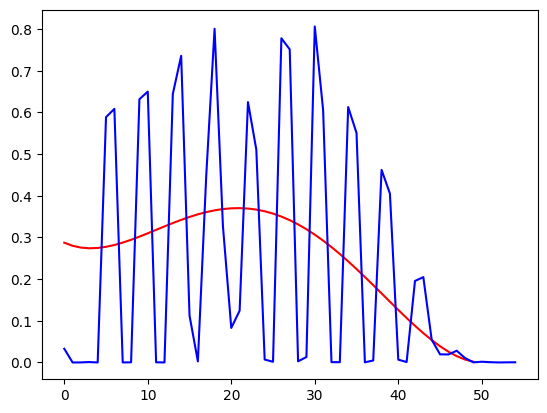

In [24]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# pickle.dump([vehicle_location.x, vehicle_location.y, vehicle_location.heading_angle, vehicle_location.velocity], open("/home/shaohang/work_space/autonomous_vehicle/ISS/vehicle_location.pkl", "wb"))
# pickle.dump(self.traj, open("/home/shaohang/work_space/autonomous_vehicle/ISS/traj.pkl", "wb"))

current_state = pickle.load(open("/home/shaohang/work_space/autonomous_vehicle/ISS/vehicle_location.pkl", "rb"))
traj = pickle.load(open("/home/shaohang/work_space/autonomous_vehicle/ISS/traj.pkl", "rb"))
recorded_states = pickle.load(open("/home/shaohang/work_space/autonomous_vehicle/ISS/recorded_states.pkl", "rb"))

plt.figure()
plt.axes().set_aspect('equal')
traj = np.array(traj)
recorded_states = np.array(recorded_states)
plt.plot(traj[:, 0], traj[:, 1], 'r')
plt.plot(recorded_states[:, 0], recorded_states[:, 1], 'b')

plt.figure()
plt.plot(traj[:, 0], "r")
plt.plot(recorded_states[:, 0], "b")

plt.figure()
plt.plot(traj[:, 1], "r")
plt.plot(recorded_states[:, 1], "b")

plt.figure()
plt.plot(traj[:, 2], "r")
plt.plot(recorded_states[:, 2], "b")

plt.figure()
plt.plot(traj[:, 3], "r")
plt.plot(recorded_states[:, 3], "b")

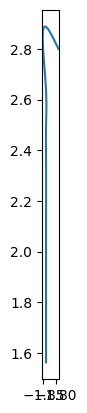

In [26]:
import matplotlib.pyplot as plt
path = [(-1.789859992759739, 2.7999053866768824, 2.0949643888228637), (-1.7899185284908345, 2.8000066403740975, 2.030578848975729), (-1.7903401685363003, 2.800858132362225, 2.024995413089962), (-1.7914468528885479, 2.803124792361756, 2.023664285567911), (-1.793516061456318, 2.8073771981512063, 2.0239304750277176), (-1.7967772668179127, 2.814074730365653, 2.026166655580387), (-1.801398907699714, 2.823512509472351, 2.0320298484646035), (-1.807459218444204, 2.8357066365991357, 2.0449893006808466), (-1.8148945359000466, 2.8501933145329263, 2.072837168175138), (-1.8234207367256459, 2.8657249974759127, 2.138110127060429), (-1.8324273458940046, 2.8798599905154156, 2.3457768228359552), (-1.8408589465168501, 2.888469122241784, -2.874412325502579), (-1.8474770929010715, 2.8866575711151907, -1.8335594658042258), (-1.8514676854210939, 2.8718216842844044, -1.6083981571461323), (-1.8525594226969169, 2.842801216870927, -1.531013663023792), (-1.8508591836755797, 2.800085576472719, -1.4993688548691817), (-1.8470100125164157, 2.746288027433193, -1.491969793725119), (-1.8422844218117032, 2.6864630067760573, -1.5080674619654706), (-1.8386293741163637, 2.6282720550984267, -1.5499244813887716), (-1.837576073666489, 2.577814250634953, -1.5869776448969917), (-1.8383132377686413, 2.532261733966617, -1.5926219223453262), (-1.8393209191634867, 2.4860993563031473, -1.5750650400362456), (-1.8395365864857982, 2.435576868574574, -1.5655219685108193), (-1.8392547449071024, 2.382141180286495, -1.565445956348064), (-1.8389650368380857, 2.3279944053199557, -1.5689968386872626), (-1.8388683097482372, 2.274241904799279, -1.5714817267870438), (-1.8389048039793428, 2.220996754800775, -1.5726795942376866), (-1.8390039880074993, 2.1683308887403165, -1.5725723829359821), (-1.8390963678314243, 2.11631692102028, -1.5714404095435608), (-1.8391293651087044, 2.0650855027193527, -1.5705876916418733), (-1.8391189194963111, 2.0150190968891555, -1.5703996772732827), (-1.839099697647191, 1.9665585616693013, -1.5706555462607135), (-1.8390931540917292, 1.920078020474865, -1.5708503983129618), (-1.8390955463257919, 1.8758359842626495, -1.5709094544920665), (-1.839100272685958, 1.8340570011824486, -1.5708694126935308), (-1.8391031309826384, 1.79494827119784, -1.5708229586255424), (-1.839104096264369, 1.7587028570858698, -1.57079313957744), (-1.8391039903893749, 1.7254842281274254, -1.5707768496501024), (-1.8391034048050197, 1.6954190229166968, -1.5707710797460261), (-1.8391027275482628, 1.668593837912678, -1.5707730152402928), (-1.8391021787524182, 1.6450520427054578, -1.570780116978821), (-1.8391018503183052, 1.624790609049918, -1.5707901862522942), (-1.8391017457223453, 1.6077569417241093, -1.5708014110487774), (-1.839101816450626, 1.593845700773632, -1.570812391658068), (-1.8391019923623828, 1.5828956070924856, -1.5708217446894641), (-1.8391022010276847, 1.5746862213258177, -1.5708279708792134), (-1.8391023830291284, 1.5689347057562317, -1.5708318454245926), (-1.8391025123923148, 1.565292583651914, -1.5708342619253848), (-1.839102586371127, 1.5633424437367502, -1.5708357769783239), (-1.8391026158721278, 1.5625946398439634, -1.5708357769783239)]
path_array = np.array(path)
plt.plot(path_array[:, 0], path_array[:, 1])
plt.axes().set_aspect('equal')